In [519]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt



In [520]:
MODEL = "RandomForest" # Options: "RandomForest", "LogisticRegression"
DATASET = "OpenStack"  # Options: "OpenStack", "Linux"

In [521]:
if DATASET == "OpenStack":
    df = pd.read_csv('../../resources/openstack/log-structured/OpenStack.log_sequences.csv')
elif DATASET == "Linux":
    df = pd.read_csv('../../resources/linux/log-structured/Linux.log_sequences.csv')
else:
    raise ValueError(f"Unsupported dataset {DATASET}, please choose either 'OpenStack' or 'Linux'.")

In [522]:
X = df.iloc[:, 1:-1].values
y = df["Severity"].values

In [523]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [524]:
if MODEL == "RandomForest":
    model = RandomForestClassifier(
        n_estimators=100,  # number of trees
        max_depth=None,    # let trees expand until all leaves are pure
        random_state=42
    )
elif MODEL == "LogisticRegression":
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
else:
    raise ValueError(f"Unsupported model {MODEL}, please choose either 'RandomForest' or 'LogisticRegression'.")



In [525]:
# To store metrics
accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []

# To store all predictions
y_true_all = []
y_pred_all = []
y_proba_all = []

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # probabilities for class 1

    # Store results for combined confusion matrix
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)
    y_proba_all.extend(y_proba)

    # Compute metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_proba))

# Convert lists to arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_proba_all = np.array(y_proba_all)

metrics = {
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "AUC": aucs
}

metric_names = list(metrics.keys())
means = [np.mean(metrics[m]) for m in metric_names]
stds = [np.std(metrics[m]) for m in metric_names]

# Print results
for name, mean, std in zip(metric_names, means, stds):
    print(f"{name}: {mean:.4f} ± {std:.4f}")


Accuracy: 1.0000 ± 0.0000
Precision: 1.0000 ± 0.0000
Recall: 1.0000 ± 0.0000
AUC: 1.0000 ± 0.0000


<Figure size 500x500 with 0 Axes>

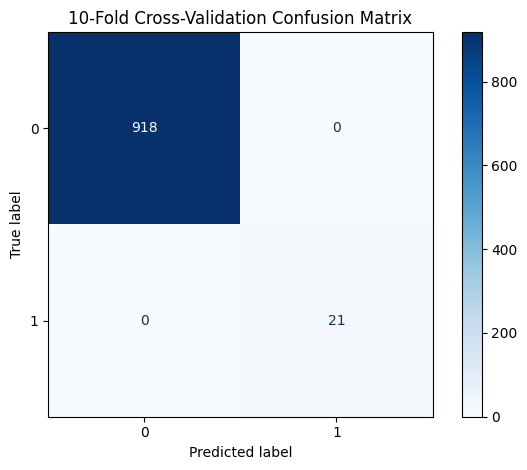

In [526]:
# ===== 📊 1. Confusion Matrix =====
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5, 5))
disp.plot(cmap="Blues", colorbar=True)
plt.title("10-Fold Cross-Validation Confusion Matrix")
plt.tight_layout()
plt.savefig(f"../../resources/images/cv_confusion_matrix_{MODEL}_{DATASET}.png", dpi=300)
plt.show()

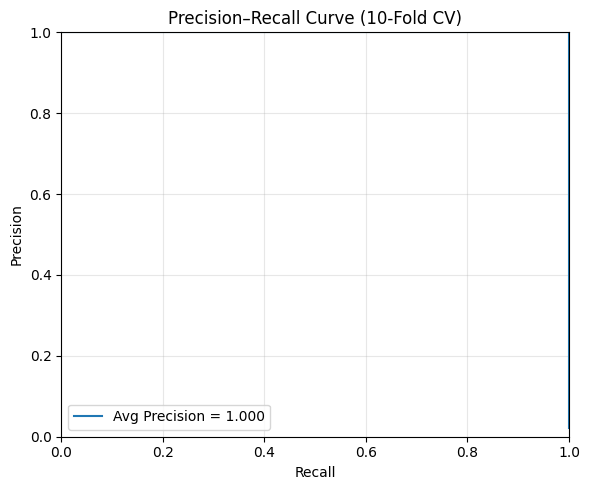

In [527]:
# ===== 📈 2. Precision–Recall Curve =====
precision, recall, thresholds = precision_recall_curve(y_true_all, y_proba_all)
avg_precision = average_precision_score(y_true_all, y_proba_all)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis((0.0, 1.0, 0.0, 1.0))
plt.title("Precision–Recall Curve (10-Fold CV)")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"../../resources/images/cv_precision_recall_curve_{MODEL}_{DATASET}.png", dpi=300)
plt.show()

In [528]:
event_names = list(df.columns)[1:-1] # if hasattr(X_train, 'columns') else [f"E{i+1}" for i in range (len(coefficients))]

if MODEL == "LogisticRegression":
    # Get absolute value of coefficients (importance)
    coefficients = model.coef_[0]  # shape = (n_features,)
    importance = np.abs(coefficients)
elif MODEL == "RandomForest":
    importance = abs(model.feature_importances_)

# Get feature importances
feature_importance = pd.DataFrame({
    "EventId": event_names,
    "Importance": importance
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

print(feature_importance.head(10))

             EventId  Importance
60  request-b957f59c    0.869649
45  request-416be887    0.047455
57  request-a17e98d9    0.011913
38  request-2290cbde    0.010724
44  request-3bc56d04    0.009384
58  request-a94c0777    0.005572
48  request-5b709354    0.004827
33  request-0b0d8533    0.003868
54  request-8dae7505    0.003356
52  request-7f07883c    0.003230


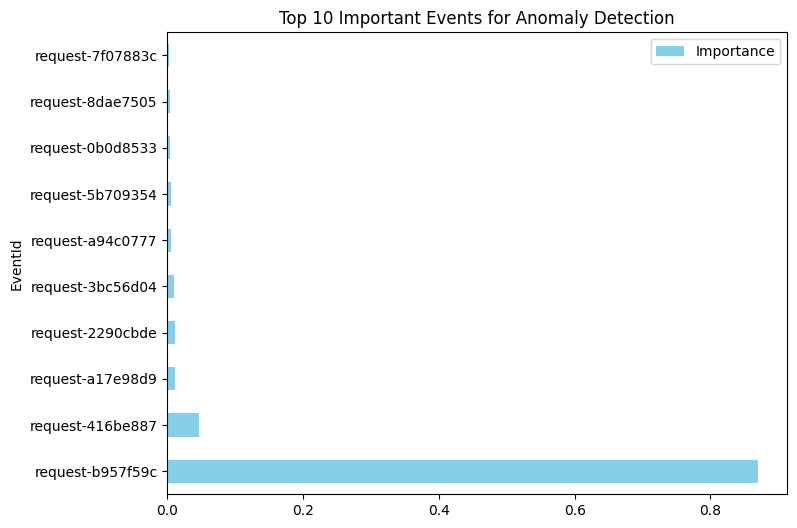

In [529]:
import matplotlib.pyplot as plt

feature_importance.head(10).plot(
    x="EventId", y="Importance", kind="barh", figsize=(8,6), color="skyblue"
)
plt.title("Top 10 Important Events for Anomaly Detection")
plt.savefig(f"../../resources/images/top10_feature_importance_{MODEL}_{DATASET}.png", dpi=300)
plt.show()
